In [112]:
from clearml import Dataset
from PIL import Image
import os
import torch

from utils import remove_suffix

from torchvision.transforms import ToTensor

import importlib
import detector
importlib.reload(detector)

%matplotlib inline

In [130]:
crd = detector.CropRowDetector(crop_merge_multiplier=1, displacement_function=detector.mean_displacement)

Some weights of the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 were not used when initializing SegformerModel: ['decode_head.linear_c.0.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked']
- This IS expected if you are initializing SegformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Segforme

In [4]:
name = "SpringWheatCropRows"

In [5]:
dataset = Dataset.get(dataset_name=name)

In [6]:
versions = map(lambda x: x['id'], Dataset.list_datasets(partial_name=name))
datasets = list(map(lambda id: Dataset.get(dataset_id=id), versions))

In [7]:
datasets_dict = list(map(lambda x: {'dataset': x, 'path': x.get_local_copy()}, datasets))

In [8]:
datasets_dict

[{'dataset': <clearml.datasets.dataset.Dataset at 0x7f01e6643eb0>,
  'path': '/home/pasquale/.clearml/cache/storage_manager/datasets/ds_480be5c599dd419bb940bbf606cca54d'},
 {'dataset': <clearml.datasets.dataset.Dataset at 0x7f01e4d1ec10>,
  'path': '/home/pasquale/.clearml/cache/storage_manager/datasets/ds_e5ea82efea49419c8e81110c73c0d672'},
 {'dataset': <clearml.datasets.dataset.Dataset at 0x7f01e43d47f0>,
  'path': '/home/pasquale/.clearml/cache/storage_manager/datasets/ds_a227be2daaeb4f70b0da229524f407e1'},
 {'dataset': <clearml.datasets.dataset.Dataset at 0x7f01e3a84a30>,
  'path': '/home/pasquale/.clearml/cache/storage_manager/datasets/ds_66d6f3e0f4374d068ca90a5650cb7d7a'},
 {'dataset': <clearml.datasets.dataset.Dataset at 0x7f01e31b7e80>,
  'path': '/home/pasquale/.clearml/cache/storage_manager/datasets/ds_fd04fdfd396f4a03b23e90ed77e8607f'},
 {'dataset': <clearml.datasets.dataset.Dataset at 0x7f01e286cca0>,
  'path': '/home/pasquale/.clearml/cache/storage_manager/datasets/ds_0787

In [35]:
files = set(map(lambda x: remove_suffix(x.split('.')[0], '_mask'), os.listdir(datasets_dict[0]['path'])))
images = list(map(lambda x: x + '.JPG', files))
masks = list(map(lambda x: x + '_cropmask.png', files))

DJI_2073_5.JPG


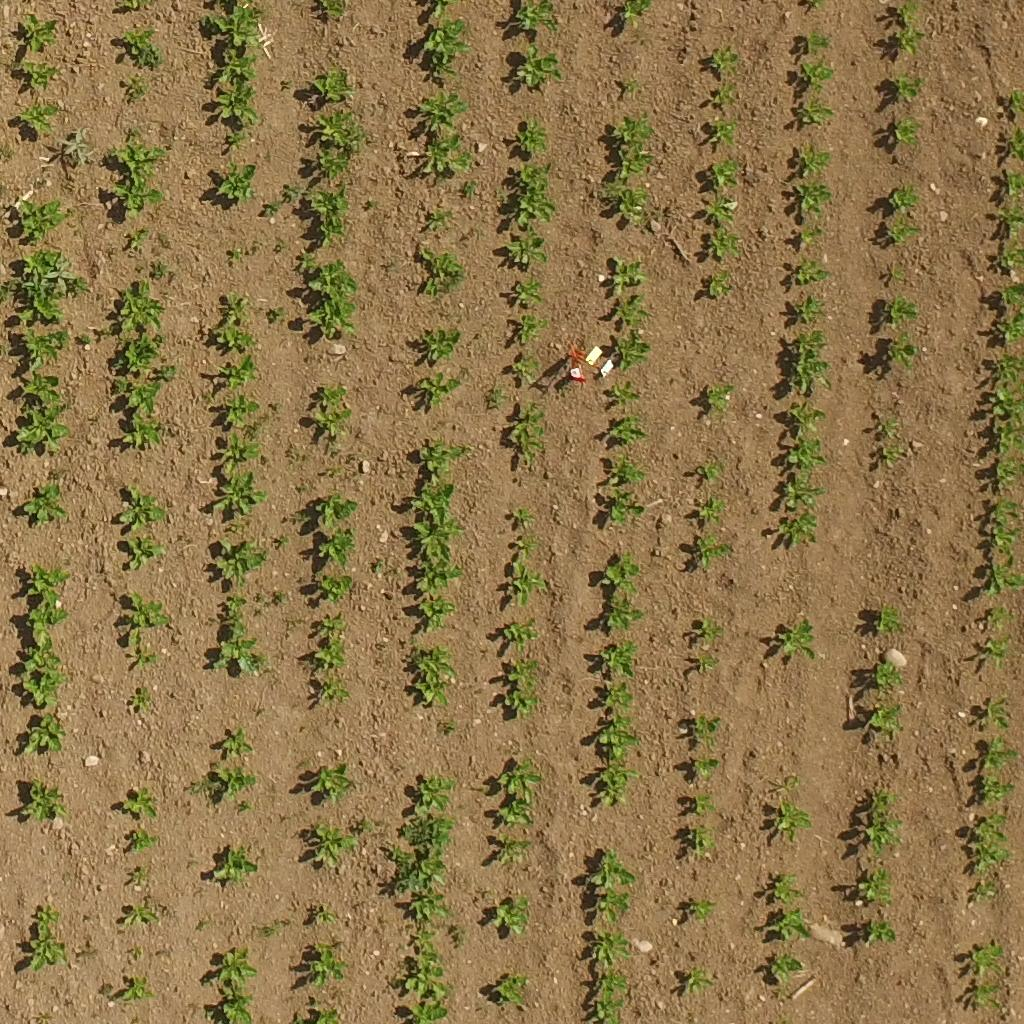

In [149]:
idx = 50
image_path = os.path.join(datasets_dict[0]['path'], images[idx])
image = Image.open(image_path)
print(images[idx])
image

In [26]:
img_tensor = ToTensor()(image)

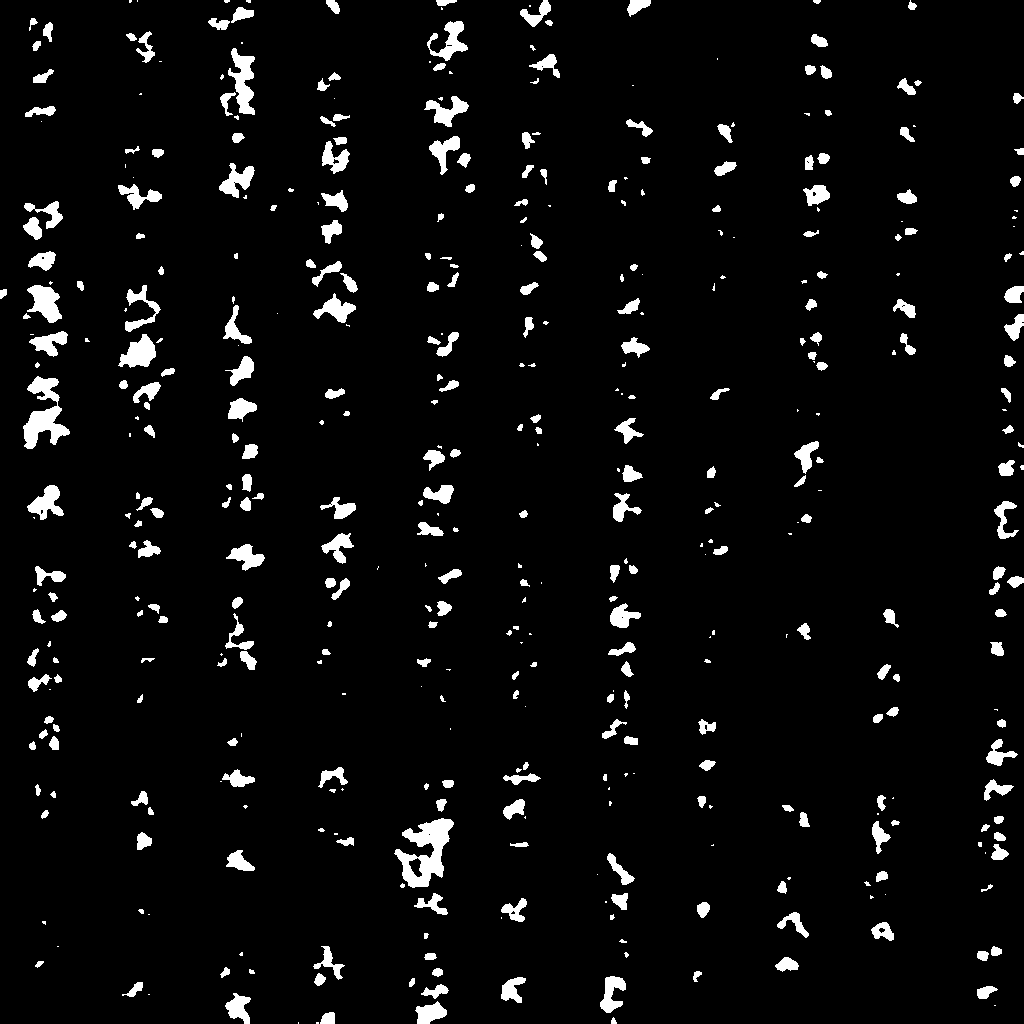

In [36]:
mask_path = os.path.join(datasets_dict[0]['path'], masks[idx])
mask = Image.open(mask_path)
mask

In [139]:
crop_mask = ToTensor()(mask).cuda().squeeze(0).type(torch.uint8)
width, height = crop_mask.shape
connectivity_df = crd.calculate_connectivity(crop_mask)
enhanced_mask = crd.calculate_mask((width, height), connectivity_df)

In [140]:
recall_connectivity_df = crd.increase_recall(connectivity_df.clone())

In [144]:
recall_connectivity_df.shape

torch.Size([436, 8])

In [148]:
connectivity_df[:, 6]

tensor([ 3,  1,  6,  5, 14, 21, 31, 24,  8,  9,  2, 23,  2,  9, 22, 41,  8, 10,
        19, 11, 17,  9,  2,  6, 27, 31,  1,  3,  2, 13, 11, 12, 21,  4, 13,  4,
        13,  9, 19,  8,  2,  3, 16, 11,  5, 45,  1, 31,  7,  6,  5, 17, 16, 27,
         1,  4, 16,  3, 15, 13, 13,  9, 14, 31, 28, 15, 12, 10, 14, 13,  9, 10,
        23, 36,  1, 12,  7,  1,  4, 11,  9, 44, 10, 27,  6,  4, 20, 27,  4, 14,
        39,  5,  2,  7,  3,  9,  3,  4,  7, 19,  7,  5, 21,  2,  2, 13,  5, 16,
         9, 13,  7,  2,  1, 28, 14,  5,  4,  6,  8, 12, 10, 30,  9,  8,  6, 11,
        18, 12,  4,  4,  1,  6,  4,  7,  6, 12, 19,  3, 35, 36, 20,  7, 43,  3,
        23, 12, 23, 29,  3,  8,  1,  4, 20, 11,  6,  4, 39,  2, 23, 12, 16,  4,
        38, 14, 29,  5,  7,  6,  1,  4,  9, 12, 29,  2,  5,  6,  8,  4, 12, 14,
         6, 47,  9, 20, 28, 20,  4, 20, 10,  2,  8, 29,  7,  6,  2,  5,  7,  4,
        11,  4, 30,  5, 11,  6, 12,  7,  2,  7, 25,  2,  6, 16,  5, 11, 22,  8,
        17, 21,  4,  9,  3, 10, 12, 37, 

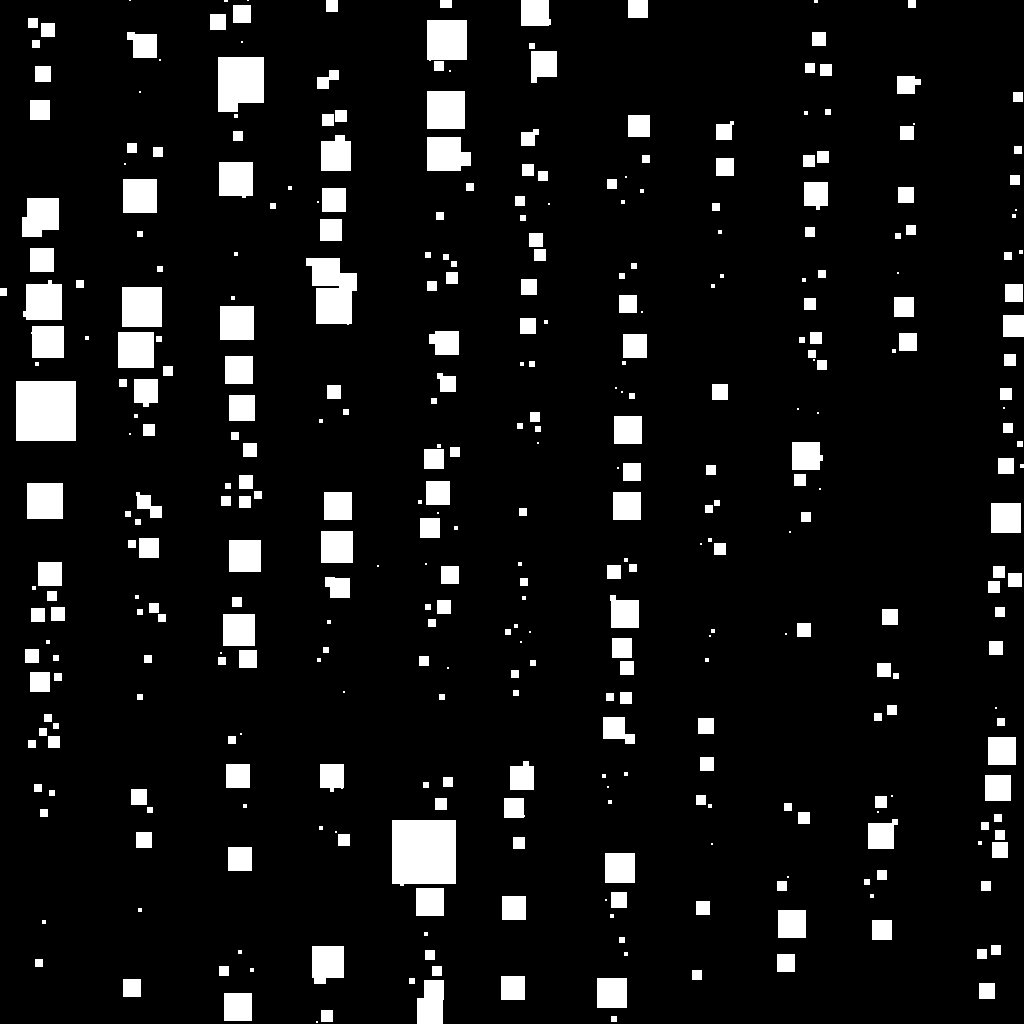

In [142]:
Image.fromarray(enhanced_mask.cpu().numpy())

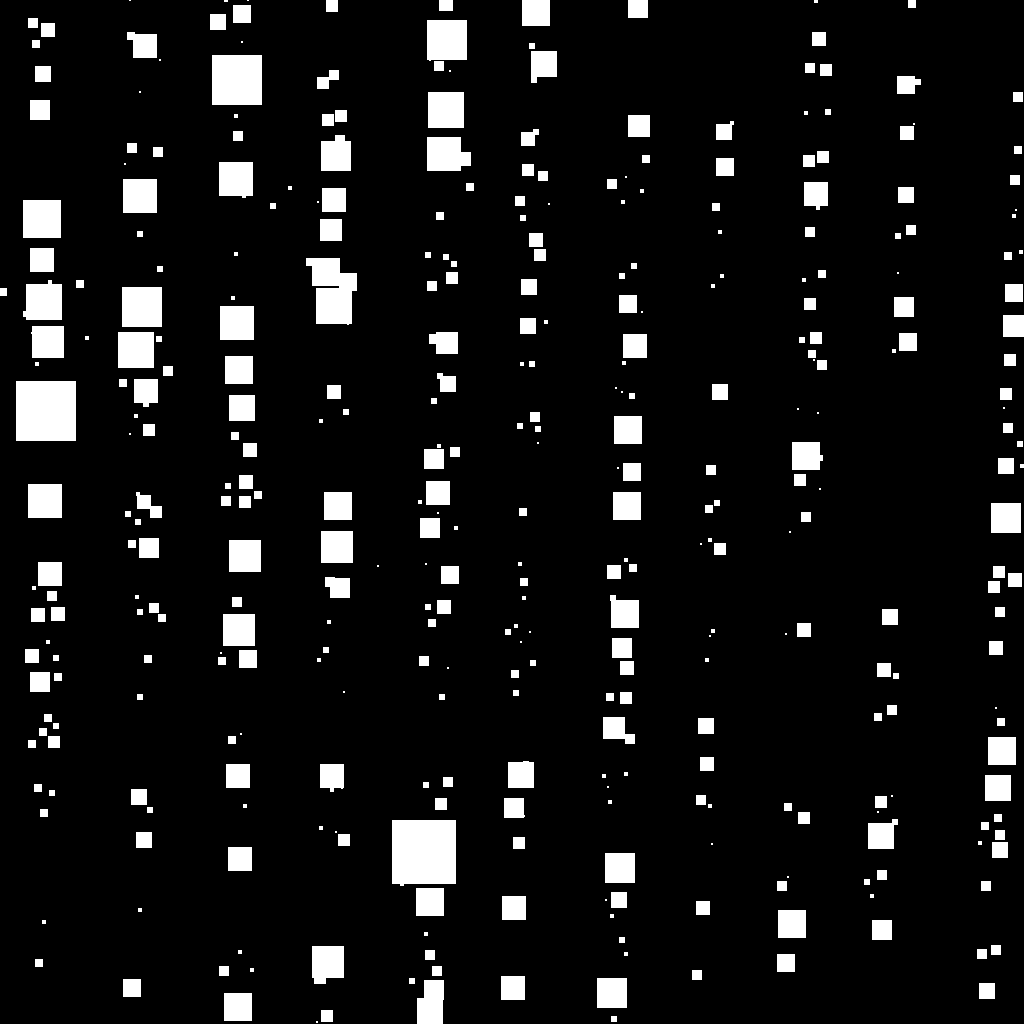

In [143]:
recall_enhanced_mask = crd.calculate_mask((width, height), recall_connectivity_df)
Image.fromarray(recall_enhanced_mask.cpu().numpy())